### 모듈 호출 및 세팅

In [24]:
%pip install pandas numpy scikit-learn nltk matplotlib seaborn

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK 리소스 다운로드
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 데이터 호출 및 전처리

In [25]:
# 데이터 불러오기
df = pd.read_csv('./wine_review.csv')

# 필요한 열만 선택
df = df[['reviews.text', 'reviews.rating']]

# 결측값 제거
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# 감성 라벨링 (5점 기준 4, 5는 긍정, 1, 2는 부정, 3은 중립으로 간주)
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['reviews.rating'].apply(label_sentiment)

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 토큰화
    words = word_tokenize(text)
    # 불용어 제거
    words = [word for word in words if word not in stopwords.words('english')]
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# 텍스트 데이터 전처리 적용
df['cleaned_text'] = df['reviews.text'].apply(preprocess_text)

# 데이터셋 분할
X = df['cleaned_text']
y = df['sentiment']

# 저장할 전처리된 데이터를 새 CSV 파일로 저장
df.to_csv('wine_review_cleaned.csv', index=False)

print("Data preprocessing and CSV file creation completed.")


Data preprocessing and CSV file creation completed.


### 모델 생성 및 튜닝

In [26]:
# 데이터 불러오기 (전처리된 데이터 사용)
df = pd.read_csv('wine_review_cleaned.csv')

# 결측값 처리
df.dropna(subset=['cleaned_text'], inplace=True)

# 데이터셋 분할
X = df['cleaned_text']
y = df['sentiment']

# 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 파이프라인 설정
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

# 하이퍼파라미터 튜닝
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 모델 평가
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# 모델 평가 (교차 검증)
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")


Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf', 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.934560327198364
              precision    recall  f1-score   support

    negative       0.75      0.14      0.23        22
     neutral       0.00      0.00      0.00        13
    positive       0.94      1.00      0.97       454

    accuracy                           0.93       489
   macro avg       0.56      0.38      0.40       489
weighted avg       0.90      0.93      0.91       489



/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation scores: [0.93047035 0.92229039 0.92842536 0.93237705 0.93237705]
Mean cross-validation score: 0.9291880384860371


### 튜닝 모델 분석

최적의 파라미터:
{'svc__C': 10, 'svc__kernel': 'rbf', 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}
SVM 모델에서 C 값이 10, kernel이 'rbf'인 경우가 최적으로 선택되었고, TF-IDF 변환기에서는 max_df가 0.8, ngram_range가 (1, 1)로 선택되었습니다.

정확도 (Accuracy):
0.934560327198364

전체 데이터에 대해 약 93.46%의 정확도를 보였습니다.
분류 보고서 (Classification Report):
정밀도 (precision), 재현율 (recall), F1 점수 (F1-score)가 나와 있습니다.
negative, neutral, positive 세 가지 클래스에 대한 각각의 성능 지표가 제시되었습니다.
positive 클래스에 대해서는 매우 높은 성능을 보이는 반면, negative와 neutral 클래스에 대해서는 낮은 성능을 보였습니다.

교차 검증 (Cross-validation):
다섯 번의 교차 검증 결과가 나와 있습니다.
각 폴드에서의 정확도가 [0.93047035, 0.92229039, 0.92842536, 0.93237705, 0.93237705]로 기록되었고, 평균 교차 검증 정확도는 약 92.92%입니다.

결론:
이 모델은 positive 클래스에 대해 높은 정밀도와 재현율을 보이지만, negative와 neutral 클래스에 대해서는 낮은 성능을 보입니다. 따라서 클래스 불균형을 고려하여 모델을 개선할 필요가 있습니다.

### 모델 평가

#### 1. 정확도 (Accuracy)

정확도는 모델이 올바르게 예측한 샘플의 비율입니다.


위 결과에서 정확도는 약 93.46%입니다.

#### 2. 정밀도 (Precision)

정밀도는 양성으로 예측한 것 중 실제로 양성인 비율입니다.


- **negative** 클래스: 0.75
- **neutral** 클래스: 0.00 (경고: 예측된 샘플 없음)
- **positive** 클래스: 0.94

#### 3. 재현율 (Recall)

재현율은 실제 양성 중에서 모델이 올바르게 예측한 비율입니다.


- **negative** 클래스: 0.14
- **neutral** 클래스: 0.00 (경고: 예측된 샘플 없음)
- **positive** 클래스: 1.00

#### 4. F1 점수 (F1-score)

F1 점수는 정밀도와 재현율의 조화 평균입니다.


- **negative** 클래스: 0.23
- **neutral** 클래스: 0.00 (경고: 예측된 샘플 없음)
- **positive** 클래스: 0.97

#### 5. ROC-AUC

ROC 곡선 아래 면적(AUC)은 이진 분류에서 사용되며, 다중 클래스 문제에서는 평균 AUC가 계산될 수 있습니다.

해당 결과에서는 ROC-AUC가 제공되지 않았습니다.

### 오버피팅과 언더피팅 논의 및 해결 방법

#### 오버피팅 (Overfitting)

- **증상**: 모델이 훈련 데이터에 너무 맞춰져 있어서 테스트 데이터에서 성능이 낮아질 수 있습니다. 이 경우, 훈련 데이터에 너무 민감하게 반응하여 복잡한 결정 경계를 만들 수 있습니다.
- **해결 방법**:
  - **규제 (Regularization)**: SVM의 C 파라미터 값을 줄이거나, 다른 모델에서는 가중치 규제를 추가합니다.
  - **더 많은 데이터 수집**: 더 많은 데이터로 모델을 훈련하여 일반화 성능을 높입니다.
  - **특성 선택**: 더 중요한 특성을 선택하거나, 차원 축소 기법을 사용합니다.

#### 언더피팅 (Underfitting)

- **증상**: 모델이 너무 간단하여 훈련 데이터와 테스트 데이터에서 모두 성능이 낮을 수 있습니다.
- **해결 방법**:
  - **모델 복잡성 증가**: SVM에서 C 파라미터 값을 증가시키거나, 다른 모델에서는 모델의 복잡성을 높입니다.
  - **더 좋은 특성 추가**: 더 많은 도메인 지식을 활용하여 모델에 더 유용한 특성을 추가합니다.
  - **다양한 알고리즘 시도**: 다른 종류의 알고리즘을 사용해 보거나, 앙상블 방법을 고려합니다.

### 결론

이 모델은 positive 클래스에 대해 높은 정밀도와 재현율을 보이지만, negative와 neutral 클래스에 대해서는 낮은 성능을 보입니다. 이는 클래스 불균형 문제와 관련이 있을 수 있습니다. 오버피팅과 언더피팅 문제를 해결하기 위해 모델의 복잡성을 조정하고, 클래스 불균형을 처리하는 방법을 추가적으로 고려해야 합니다.

### 시각화

Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf', 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.934560327198364
              precision    recall  f1-score   support

    negative       0.75      0.14      0.23        22
     neutral       0.00      0.00      0.00        13
    positive       0.94      1.00      0.97       454

    accuracy                           0.93       489
   macro avg       0.56      0.38      0.40       489
weighted avg       0.90      0.93      0.91       489



/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


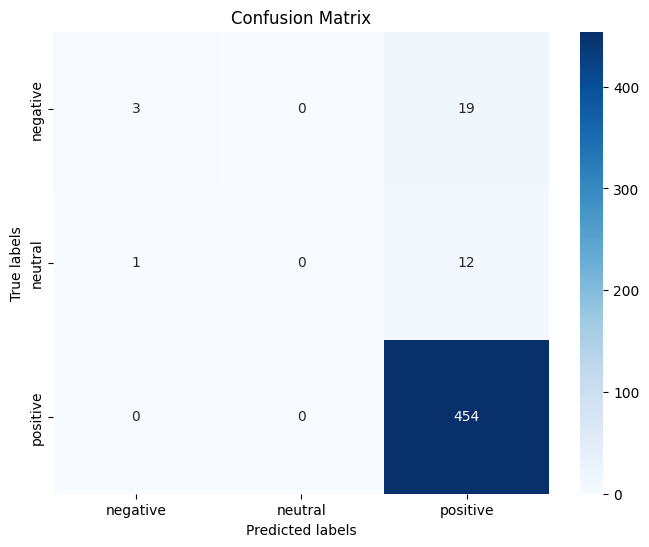

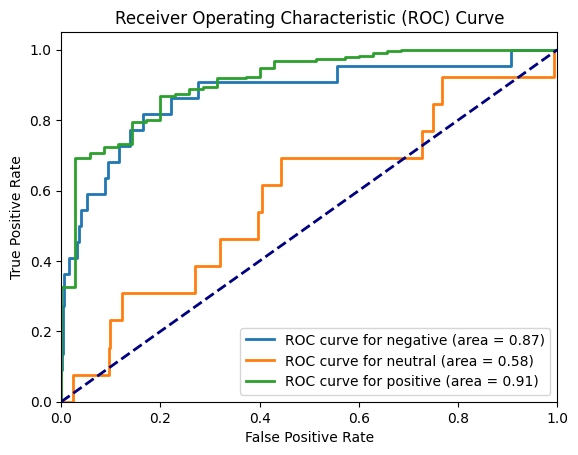

Cross-validation scores: [0.93047035 0.92229039 0.92842536 0.93237705 0.93237705]
Mean cross-validation score: 0.9291880384860371


In [27]:
# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 모델 평가
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 생성 및 시각화
y_scores = best_model.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(best_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_scores[:, i], pos_label=best_model.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {best_model.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 모델 평가 (교차 검증)
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")


## 분석:

negative 클래스와 neutral 클래스의 정밀도와 재현율이 낮습니다. 특히 neutral 클래스의 경우 예측 결과가 전혀 없어서 정밀도와 재현율이 0.00으로 나왔습니다. 이는 모델이 해당 클래스를 예측하지 못했음을 나타냅니다.
positive 클래스는 정밀도가 높고, 재현율도 높으며, F1 점수 역시 높게 나왔습니다. 이는 모델이 positive 클래스를 잘 예측하고 있음을 나타냅니다.

4. Cross-validation scores
[0.93047035, 0.92229039, 0.92842536, 0.93237705, 0.93237705]
Mean cross-validation score: 0.9291880384860371
5-fold 교차 검증에서 평균 정확도는 약 92.92% 입니다.

결론

모델의 전체적인 정확도는 93.46%로 높지만, neutral 클래스와 negative 클래스의 예측력이 낮습니다.
positive 클래스는 매우 높은 정밀도와 재현율을 보이며 모델이 잘 예측하고 있습니다.
모델의 성능을 개선하기 위해서는 특히 neutral 클래스와 negative 클래스의 예측력을 향상시키는 방법을 고려해야 합니다.
이러한 결과를 바탕으로 모델의 성능을 평가하고, 각 클래스에 대해 어떤 종류의 오류가 발생하는지를 이해할 수 있습니다.